In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [68]:
import os
from google.colab import drive
path= drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1.0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1.0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0.0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0.0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0.0


In [70]:
# Optimization: Load only necessary columns to save RAM
cols = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
        'oldbalanceDest', 'newbalanceDest', 'isFraud']

In [71]:
path = '/content/Fraud.csv'

In [73]:
# Methodological Shift: Filter for TRANSFER and CASH_OUT during load
# These are the only types where fraud occurs in this dataset
chunks = pd.read_csv(path, usecols=cols, chunksize=500000)
df = pd.concat([chunk[(chunk['type'] == 'TRANSFER') | (chunk['type'] == 'CASH_OUT')] for chunk in chunks])
print(f"Filtered Dataset Size: {df.shape}")

Filtered Dataset Size: (20939, 8)


In [60]:
df.isnull().sum().sum()

np.int64(0)

In [61]:
df.duplicated().sum()

np.int64(0)

In [62]:
#FEATURE ENGINEERING
# Feature 1: Balance Discrepancy (Origin)
# Logic: oldbalance - amount should = newbalance. If not, error exists.
df['errorBalanceOrg'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']

# Feature 2: Balance Discrepancy (Destination)
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# Feature 3: Time of Day (Step is in hours)
df['hour'] = df['step'] % 24

# Feature 4: Zero Balance Flag (Common in fraud to drain an account to exactly 0)
df['is_zero_balance_orig'] = (df['newbalanceOrig'] == 0).astype(int)

# Drop 'step' as we extracted 'hour'
df.drop('step', axis=1, inplace=True)

In [63]:
#DATA CLEANING AND DATA ENCODING(Convert text data into numbers so ML model can read it)
# Convert 'type' to binary/dummy variables
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Define X (features) and y (target)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

print("Features selected:", X.columns.tolist())

Features selected: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrg', 'errorBalanceDest', 'hour', 'is_zero_balance_orig', 'type_TRANSFER']


In [64]:
#Handling class imbalance(SMOTE)-Since fraud is only ~0.1% of the data, we use SMOTE to create synthetic fraud cases
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data FIRST (to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original Fraud Count: {sum(y_train)}")
print(f"SMOTE Fraud Count: {sum(y_train_res)}")

Original Fraud Count: 80.0
SMOTE Fraud Count: 16671.0


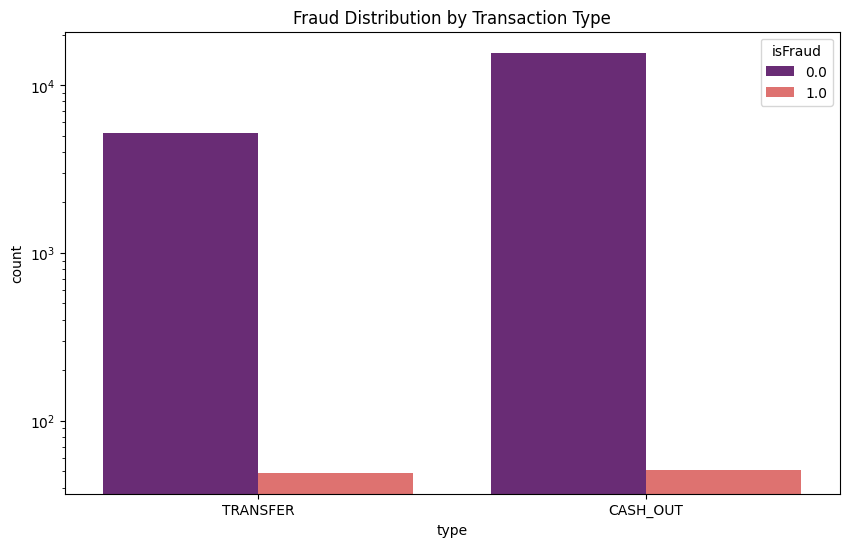

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization of Fraud across Transaction Types
plt.figure(figsize=(10,6))
ax = sns.countplot(x='type', data=df, hue='isFraud', palette='magma')
plt.title('Fraud Distribution by Transaction Type')
plt.yscale('log') # Log scale because legitimate transactions are much higher
plt.show()

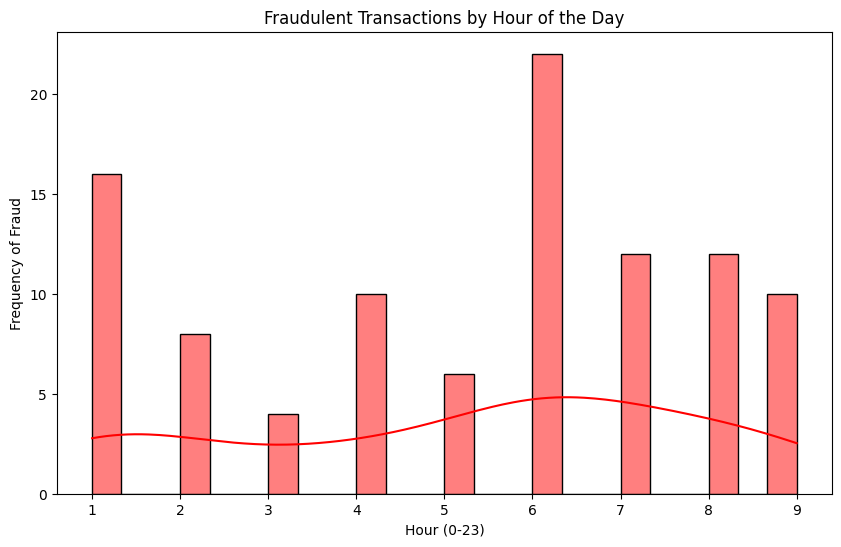

In [76]:
# Create the 'hour' feature from the 'step' column
df['hour'] = df['step'] % 24
# Analyzing fraud patterns over a 24-hour cycle
fraud_hours = df[df['isFraud'] == 1]['hour']
plt.figure(figsize=(10,6))
sns.histplot(fraud_hours, bins=24, kde=True, color='red')
plt.title('Fraudulent Transactions by Hour of the Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Frequency of Fraud')
plt.show()

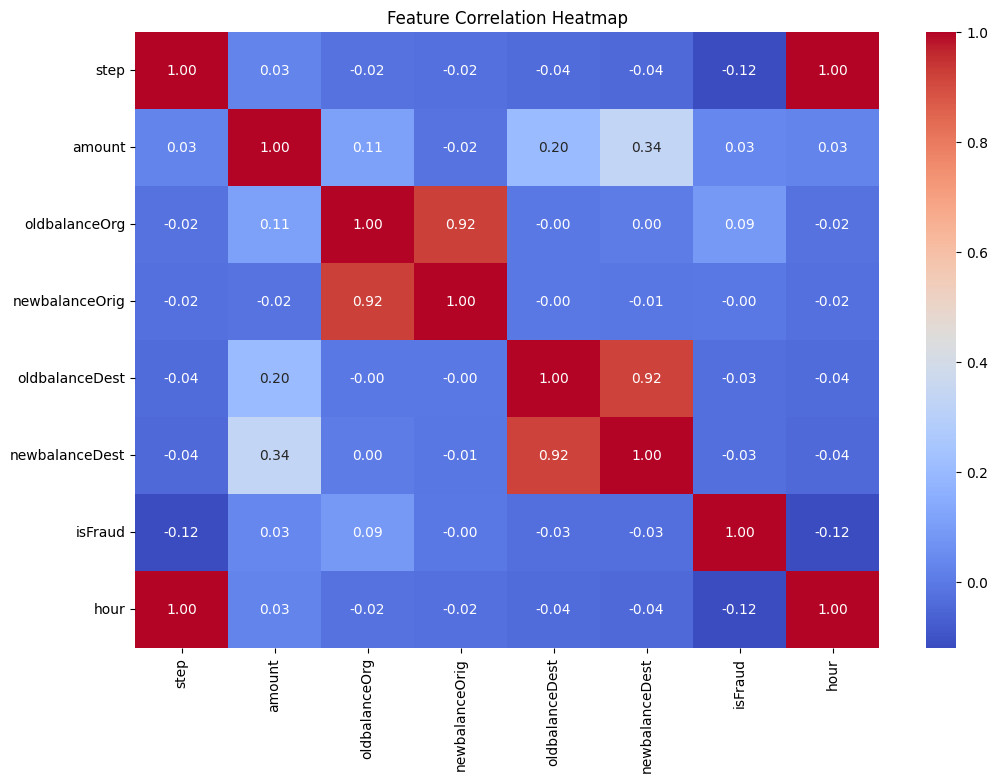

In [80]:
# Correlation Heatmap to show relationship between features and Fraud
plt.figure(figsize=(12,8))
correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()